In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy, scipy.interpolate, scipy.misc, scipy.integrate
from scipy.interpolate import interp1d

import time
import sys
sys.path.append('/Users/ap/workspace/Q0-sims')

import emcee
import corner

import obs_tools as obs
import fg_tools as fg
import pk_tools as pk

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 20, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = False

# Running PCA analysis 

In [3]:
# data:
data = pd.read_pickle('./Data/data.pkl')

HI_signal = data.nobeam.HI
HI_noise = data.nobeam.noise

HI_fg_smooth = data.beam.foregrounds.sync + data.beam.foregrounds.psource + data.beam.foregrounds.free
HI_fg_pol_leak = data.nobeam.foregrounds.pleak

FG_HI_noise_data = HI_signal+HI_noise+HI_fg_smooth+HI_fg_pol_leak #data.beam.FGwpol_HI_noise
HI_noise_data = HI_signal + HI_noise #data.beam.HI_noise

HI_noise_data_beam = data.beam.HI_noise

freqs = data.freqs

#### Perform PCA removal

In [4]:
#pca_res_1 = fg.PCAclean(FG_HI_noise_data, N_FG=1)[0]
#pca_res_2 = fg.PCAclean(FG_HI_noise_data, N_FG=2)[0]
#pca_res_3 = fg.PCAclean(FG_HI_noise_data, N_FG=3)[0]

pca_res_4 = fg.PCAclean(FG_HI_noise_data, N_FG=4)[0]
pca_res_5 = fg.PCAclean(FG_HI_noise_data, N_FG=5)[0]
pca_res_6 = fg.PCAclean(FG_HI_noise_data, N_FG=6)[0]

#pca_res_7 = fg.PCAclean(FG_HI_noise_data, N_FG=7)[0]
#pca_res_10 = fg.PCAclean(FG_HI_noise_data, N_FG=10)[0]

#### Sims specs

In [5]:
# Dimension of data cube:
lx, ly, lz = 1000,1000, 924.78 #Mpc/h
nx, ny, nz = 256, 256, 285
# weighting and window function:
w = W = np.ones((nx,ny,nz))

# minimum and maximum k in each direction:
kmin, kmin_perp, kmin_par = 2*np.pi/pow(lx*ly*lz, 1/3), 2*np.pi/np.sqrt(lx**2 + ly**2), 2*np.pi/lz
kmax, kmax_par, kmax_perp = 0.4, 0.4, 0.4

# set width of k bins to be 2*kmin
dk, dk_perp, dk_par = 2*kmin, 2*kmin_perp, 2*kmin_par

# number of k bins:
nkbin = int((kmax-kmin)/dk)
nkbin_perp = int((kmax_perp-kmin_perp)/dk_perp)
nkbin_par = int((kmax_par-kmin_par)/dk_par)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
kbins_perp = np.arange(kmin_perp,kmax_perp,dk_perp)
kbins_par = np.arange(kmin_par,kmax_par,dk_par)

# array of kbin centers:
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
kperp = np.linspace(kmin_perp+0.5*dk_perp,kmax_perp-0.5*dk_perp,nkbin_perp)
kpar = np.linspace(kmin_par+0.5*dk_par,kmax_par-0.5*dk_par,nkbin_par)

#### Calculate 3D Pk

In [6]:
# HI+noise power spectrum:
HI_pk = pk.getpk(HI_noise_data, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

# HI+noise power spectrum with beam:
HI_pk_beam = pk.getpk(HI_noise_data_beam, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

# residual power spectrum from PCA:
# PCA1_pk = pk.getpk(pca_res_1, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
# PCA2_pk = pk.getpk(pca_res_2, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
# PCA3_pk = pk.getpk(pca_res_3, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
# PCA4_pk = pk.getpk(pca_res_4, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
#PCA5_pk = pk.getpk(pca_res_5, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
#PCA6_pk = pk.getpk(pca_res_6, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
#PCA7_pk = pk.getpk(pca_res_7, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
#PCA10_pk = pk.getpk(pca_res_10, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

In [7]:
# HI signal power spectrum:
HI_signal_pk = pk.getpk(HI_signal, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

# HI noise power spectrum::
HI_noise_pk = pk.getpk(HI_noise, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

In [8]:
N_modes = pk.getpk(HI_signal, w, W, nx, ny, nz, lx, ly, lz, kbins)[1]

#### Calculate multipoles and Q0

In [9]:
P0 = pk.getpkmultipoles(HI_signal, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
P2 = pk.getpkmultipoles(HI_signal, w, W, nx, ny, nz, lx, ly, lz, kbins)[1]
P4 = pk.getpkmultipoles(HI_signal, w, W, nx, ny, nz, lx, ly, lz, kbins)[2]

Q0 = P0 -(1/2.)*P2 + (3/8.)*P4
Q2 = (3/4.)*(2*P2-5*P4)

In [10]:
PCA_P0 = pk.getpkmultipoles(pca_res_6, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA_P2 = pk.getpkmultipoles(pca_res_6, w, W, nx, ny, nz, lx, ly, lz, kbins)[1]
PCA_P4 = pk.getpkmultipoles(pca_res_6, w, W, nx, ny, nz, lx, ly, lz, kbins)[2]

PCA_Q0 = PCA_P0 -(1/2.)*PCA_P2 + (3/8.)*PCA_P4
#PCA_Q2 = (3/4.)*(2*PCA_P2-5*PCA_P4)

In [11]:
P_noise = 100*HI_noise_pk[10] #mK^2
print(P_noise)

sigmaP = (1/np.sqrt(2*N_modes)) * (P0 + P_noise)
sigmaQ = 3.5*sigmaP

14.379769470029425


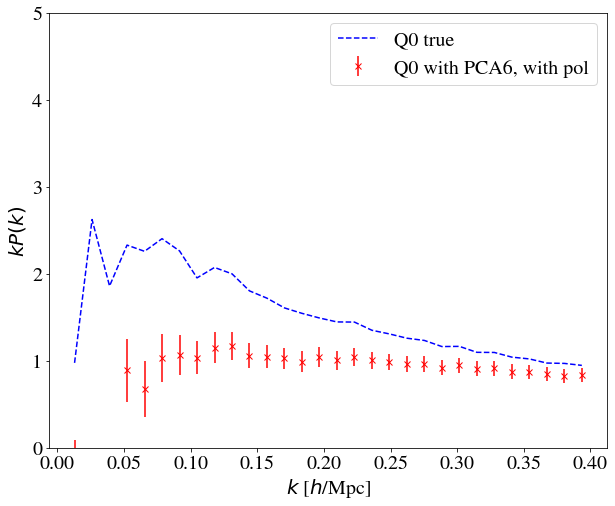

In [12]:
fig = plt.figure(figsize=(10,8))

#plt.plot(k, k*HI_pk_beam, ls='--', c='k', lw=2, label = r'HI + noise data, with beam')
#plt.plot(k, k*P0, ls='-', marker='', c='black', label = r'P0 true')
#plt.plot(k, k*P2, ls='', marker='x', c='r', label = r'P2 true')
#plt.plot(k, k*P4, ls='', marker='v', c='g', label = r'P4 true')
plt.plot(k, k*Q0, ls='--', marker='', c='blue', label = r'Q0 true')

#plt.plot(k, k*PCA_P0, ls='', marker='x', c='magenta', label = r'P0 with PCA')
plt.errorbar(k, k * PCA_Q0, yerr = k * sigmaQ, ls='', marker='x', c='red', label = r'Q0 with PCA6, with pol')


plt.xlabel('$k$ [$h$/Mpc]', fontsize=20)
plt.ylabel('$k P(k)$', fontsize=20)

plt.ylim(0,5)

plt.legend()

plt.show()

## Modelling

In [13]:
from velocileptors.LPT.cleft_fftw import CLEFT

In [14]:
#Fiducial cosmological parameters
#MULTIDARK has Planck15
c=3e5
hubble=0.678
omegab=0.048
om0 = 0.307
omegac = om0 - omegab
H00=100*hubble
Ass=2.14e-9
nss = 0.96

gamma=0.545

In [15]:
#Spatially flat Universe

#Define E(z) = H(z)/H0
def Ez(zc):
    return np.sqrt(1-om0+om0*pow(1+zc,3))
def Hz(zc):
    return Ez(zc)*H00
#Define the comoving distances
def drdz(zp):
    return (c/H00)/Ez(zp)
def rcom(zc):
    return scipy.integrate.romberg(drdz,0,zc)
def DA(zc):
    return rcom(zc)/(1+zc)

In [16]:
#Define the growth function in LCDM
def fg(zz):
    omz=om0*pow(1+zz,3)/pow(Ez(zz),2)
    return pow(omz,gamma)

print(fg(0.))

0.5254004188072541


In [17]:
#Get the growth factor 
def Dg_dz(zz):
    return -fg(zz)/(1+zz)

def Dgz(zc):
    ans = scipy.integrate.romberg(Dg_dz, 0.0, zc)
    return np.exp(ans)

In [18]:
# To match the MultiDark simulations let's
# work at z=0.39, and scale our initial power spectrum
# to that redshift:
zc = 0.39
z,D,f      = zc,Dgz(zc),fg(zc)
klin,plin  = np.loadtxt("./Data/pk.dat",unpack=True)
plin      *= D**2

In [19]:
plin_interp = scipy.interpolate.interp1d(klin,plin,kind='cubic')

In [20]:
NL_boost = np.genfromtxt('./Data/transfer_nonlinear.txt')

k_boost = NL_boost[:,0]
boost = NL_boost[:,1]

NL_boost_fun = scipy.interpolate.interp1d(k_boost,boost,kind='cubic')

In [21]:
# Initialize the class -- with no wisdom file passed it will
# experiment to find the fastest FFT algorithm for the system.
start= time.time()
cleft = CLEFT(klin,plin)
print("Elapsed time: ",time.time()-start," seconds.")
# You could save the wisdom file here if you wanted:
# mome.export_wisdom(wisdom_file_name)

Elapsed time:  0.5335640907287598  seconds.


In [22]:
# The parameters we feed it are: b1, b2, bs, b3, alpha, and sn
# The first four are deterministic Lagrangian bias up to third order
# While alpha and sn are the counterterm and stochastic term (shot noise)
#pars = [0.70, -1.3, -0.06, 0, 7.4, 0.0]
pars = [1.1, 0.5, 0.0, 0, 0.0, 0.0]
#
start= time.time()
cleft.make_ptable(nk=200)

kv, pk = cleft.combine_bias_terms_pk(*pars)

print("Elapsed time: ",time.time()-start," seconds.")

Elapsed time:  0.9669399261474609  seconds.


## Run MCMC

In [23]:
#MCMC data
k_index=0
data_mcmc = (k[k_index:], PCA_Q0[k_index:], sigmaQ[k_index:])

data_mcmc[0]

array([0.01289824, 0.02602419, 0.03915014, 0.0522761 , 0.06540205,
       0.078528  , 0.09165396, 0.10477991, 0.11790586, 0.13103182,
       0.14415777, 0.15728372, 0.17040968, 0.18353563, 0.19666158,
       0.20978754, 0.22291349, 0.23603944, 0.2491654 , 0.26229135,
       0.2754173 , 0.28854326, 0.30166921, 0.31479516, 0.32792111,
       0.34104707, 0.35417302, 0.36729897, 0.38042493, 0.39355088])

In [24]:
def lnlike(theta, x, y, yerr):    
    return -0.5 * np.sum(((y - model_ph(theta, x))/yerr) ** 2)

In [25]:
def lnprior(theta):
    
    THI,b1,b2,c1,c2 = theta
    
    if 0. < THI < 0.5 and 0. < b1 < 4.:
        return 0.0
    #if -10. < b1 < 10.:
    #    return 0.0
    #if -10. < b2 < 10.:
    #    return 0.0
    #if -100. < PN < 100.:
    #    return 0.0
    
    return -np.inf

In [26]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [27]:
'''
def model(theta,k):
    
    kv, pk = cleft.combine_bias_terms_pk(*theta)
    pk_interp = interp1d(kv,pk)
    
    res = THI_fid**2 * pk_interp(k)
    
    return res
'''

'\ndef model(theta,k):\n    \n    kv, pk = cleft.combine_bias_terms_pk(*theta)\n    pk_interp = interp1d(kv,pk)\n    \n    res = THI_fid**2 * pk_interp(k)\n    \n    return res\n'

In [28]:
kM = 0.7 

#model from https://arxiv.org/pdf/1910.07097.pdf
def model_ph(theta,k):
    
    THI,b1,b2,c1,c2 = theta
    res = THI**2 * (b1 + b2*k**2)**2 * Dgz(zc)**2 * plin_interp(k)*NL_boost_fun(k) + P_noise*(c1+c2*(k/kM)**2)
    
    return res

In [29]:
from scipy.optimize import minimize

THI_fid = 0.0737 #mK [confirmed by Steve]
bHI_fid = 1.1 #[confirmed by Steve]

#THI,b1,b2,c1,c2
initial_tmp = [THI_fid, bHI_fid, 1.0, 1.,1.] 
nll = lambda *args: -lnlike(*args)
soln = minimize(nll, initial_tmp, args=data_mcmc)

soln.x
#print(THI_fid)

array([-3.71419045e-04,  7.29282608e+01, -3.01641073e+03,  6.30186045e-01,
       -3.42322318e+00])

In [30]:
nburn = 50
niter = 1000+nburn
nwalkers = 200

In [31]:
initial = initial_tmp #soln.x 

ndim = len(initial)
p0 = [np.array(initial) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]

In [32]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data_mcmc)

print("Running production...")
pos, prob, state = sampler.run_mcmc(p0, niter,)

Running production...


In [33]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
len(samples)

200000

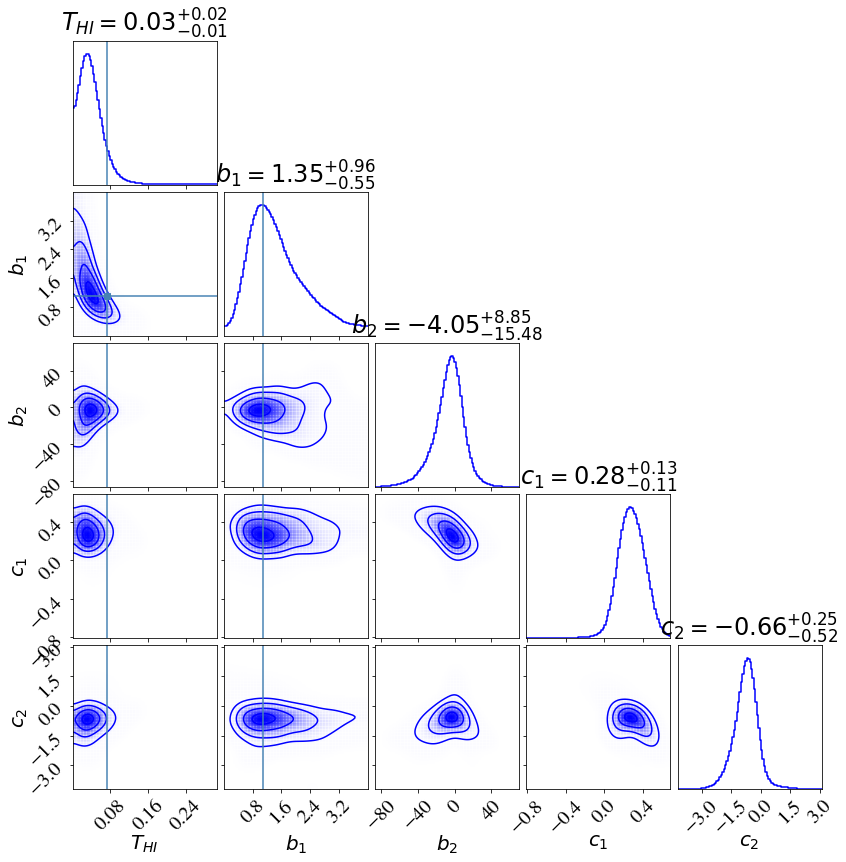

In [34]:
fig = corner.corner(samples,plot_datapoints=False, bins=100,
                    labels=["$T_{HI}$", "$b_1$","$b_2$","$c_1$","$c_2$"],
                    truths=[THI_fid,bHI_fid,1000.,1000.,1000.,], 
                    show_titles=True, smooth=5., smooth1d=5., color='blue') 

In [35]:
'''
fig = plt.figure(figsize=(10,8))

plt.plot(k, k*Q2, ls='--', marker='', c='blue', label = r'Q2 true')

plt.plot(k, k*PCA4_Q2, ls='', marker='v', c='red', label = r'Q2 with PCA4')

plt.xlabel('$k$ [$h$/Mpc]', fontsize=20)
plt.ylabel('$k P(k)$', fontsize=20)

plt.ylim(-15,10)

plt.legend()

plt.show()

'''

"\nfig = plt.figure(figsize=(10,8))\n\nplt.plot(k, k*Q2, ls='--', marker='', c='blue', label = r'Q2 true')\n\nplt.plot(k, k*PCA4_Q2, ls='', marker='v', c='red', label = r'Q2 with PCA4')\n\nplt.xlabel('$k$ [$h$/Mpc]', fontsize=20)\nplt.ylabel('$k P(k)$', fontsize=20)\n\nplt.ylim(-15,10)\n\nplt.legend()\n\nplt.show()\n\n"

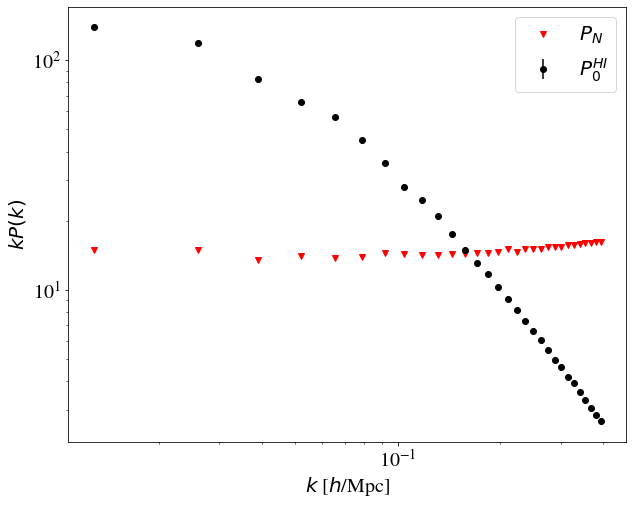

In [36]:
fig = plt.figure(figsize=(10,8))
#plt.plot(k, k * HI_signal_pk, ls='', marker='o', markersize=4, c='blue', label = r'HI signal only')

plt.errorbar(k, HI_signal_pk, yerr = k * sigmaP, ls='',marker='o',c='black', label = r'$P^{HI}_0$')
plt.plot(k, 100*HI_noise_pk, ls='', marker='v', c='red', label = r'$P_N$')

#plt.errorbar(k, k * Q0, yerr = k * sigmaQ, ls='', marker='x', c='blue', label = r'$Q^{HI}_0$')



plt.xlabel('$k$ [$h$/Mpc]', fontsize=20)
plt.ylabel('$k P(k)$', fontsize=20)

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.show()

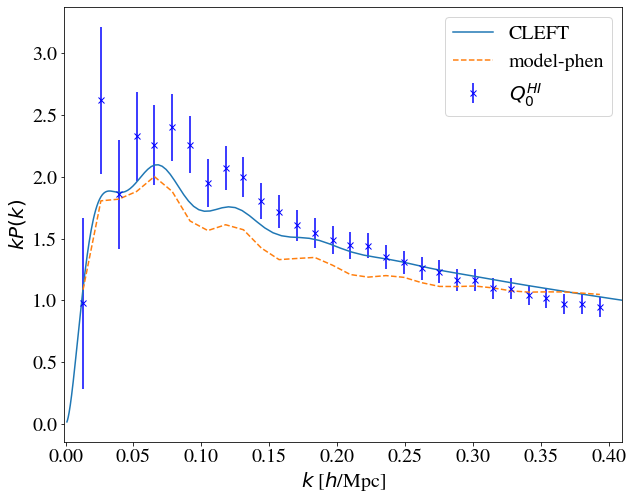

In [38]:
fig = plt.figure(figsize=(10,8))

#plt.errorbar(k, k * HI_signal_pk, yerr = k * sigmaP, ls='',marker='o',c='black', label = r'$P^{HI}_0$')
plt.errorbar(k, k * Q0, yerr = k * sigmaQ, ls='', marker='x', c='blue', label = r'$Q^{HI}_0$')

#factor = ((om0 + (1+zc)**(-3) * (1-om0))/0.37)**(-0.5) * ((1+zc)/1.8)**0.5
#OmHI_fid = 0.43
#THI_fid = 0.29 * factor * OmHI_fid/2.2 #mK

norm = 5.5 #normalisation for CLEFT model 
plt.plot(kv, kv * THI_fid**2 * pk / norm, label='CLEFT')

plt.plot(k, k * THI_fid**2 * (bHI_fid**2 * Dgz(zc)**2 * plin_interp(k)*NL_boost_fun(k)),ls='--',label='model-phen')

plt.xlabel('$k$ [$h$/Mpc]', fontsize=20)
plt.ylabel('$k P(k)$', fontsize=20)

plt.xlim(-0.001,0.41)
#plt.ylim(-0.5,6)

plt.legend()

plt.show()